# i3sense CLT panel Model validation 0.9 x 0.2 x 0.1


In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import logging
from scipy.signal import savgol_filter
from scipy.interpolate import PchipInterpolator
import re
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.optimize import curve_fit

## Load data
Load data clt_mereni (od Richarda i3sense.xlxs)
3 sheets: relativna vlhkost, teplota, hmotnost

Sample 1: r1 - r24;
Sample 2: r25 - r 48;
r49, r50 - room sensors;


In [6]:
df = pd.read_excel("clt_1d_upraveno.xlsx", sheet_name = None)

#check sheet names
for sheet_name, names in df.items():
    print(f"Sheet name: {sheet_name}")
    print(names.head())  # or print(df) if you want the full table
    print("-" * 4)

Sheet name: m
                  cas       open  reference     closed  Unnamed: 4  \
0 2024-05-18 12:41:28  8955.1279  2975.9902  8909.7920         NaN   
1 2024-05-18 12:42:28  8954.9707  2975.6990  8908.2275         NaN   
2 2024-05-18 12:43:28  8955.4414  2976.3787  8907.9600         NaN   
3 2024-05-18 12:44:28  8955.2061  2976.0000  8908.4951         NaN   
4 2024-05-18 12:45:28  8955.3721  2975.9417  8908.8018         NaN   

   Unnamed: 5  Unnamed: 6  Unnamed: 7  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  
----
Sheet name: rh_out
                  cas        r1         r2         r3         r4         r5  \
0 2024-05-18 17:00:00  39.94000  39.560265  39.910000  39.620000  40.390000   
1 2024-05-18 18:00:00  40.03000  39.661500  40.000000  39.691500  40.490000   
2 2024-05-18 19:00:00  40.19204  39.782040  40.114081  39.826121

# From RH to Moisture content - EMC

In [7]:
# get table of temperatures and set time to seconds
temp = df["t_out"].copy()

# Subtract datetime separately
datetime_col = "cas"
temp['time (s)'] = temp[datetime_col] - temp.iloc[0][datetime_col]
## Date to minutes and seconds
temp['time (s)'] = temp['time (s)'].dt.total_seconds()
#temp

# get table of humidity and set time to seconds
rh = df["rh_out"]
# Subtract datetime separately
datetime_col = "cas"
datetime_col_new = 'time (s)'
rh[datetime_col_new] = rh[datetime_col] - rh.iloc[0][datetime_col]
## Date to minutes and seconds
rh[datetime_col_new] = rh[datetime_col_new].dt.total_seconds()
#rh

In [8]:
#Create RH modified - change values over 100 in r8
rh_modified = rh.copy()

mask = rh_modified['r8'] < 100
last_lower_value = rh_modified.loc[mask, 'r8'].iloc[-1]
replace_mask = rh_modified['r8'] >= 100
rh_modified.loc[replace_mask, 'r8'] = last_lower_value

# get column names - used for loops
colnames_all = [f'r{i}' for i in range(1, 51)]
#colnames_all

## Calculate mositure content by sorption
# Value A eq. 4.38a, Horacek 1998 constants are given
A = 7.731706 - 0.014348 * (temp[colnames_all]+273.5)
B = 0.008746 + 0.000567 * (temp[colnames_all]+273.5)

In [9]:
# Create an empty DataFrame
w = pd.DataFrame()
w [datetime_col_new] = rh_modified [datetime_col_new]
w [colnames_all]= (1/B[colnames_all]) * np.log(A[colnames_all]/(np.log(1/(rh_modified[colnames_all]/100))))/100
#
w = w.drop(columns=['r8'])

In [10]:
# spilt for wetting and drying part
last_time = w[datetime_col_new].iloc[-1]
half_time = last_time/2
wetting = w[datetime_col_new] < half_time
drying = w[datetime_col_new] > half_time
#
w_wet = w [wetting]
w_dry = w [drying]
w_dry

colnames_all.remove('r8')


w_mean_overall = w_wet.drop('time (s)', axis=1).mean().mean()
w_mean_overall 

0.09674154751772482

## Ploting data

In [11]:
## Function for plotting sensors according possition
def plot_r_groups(
    df_orig,
    time_col,
    groups,
    df_smooth=None,
    plot_original=True,
    plot_smooth=True,
    title="Original vs Smoothed",
    y_label="w",
    figsize=(16, 8)
):
    """
    Plot r-columns in 2x3 subplots grouped by 'groups'.

    Parameters
    ----------
    df_orig : DataFrame
        Data with original values.
    time_col : str
        Name of the time column in df_orig (and df_smooth if used).
    groups : list of (str, list[str])
        List of (group_label, [column_names]).
    df_smooth : DataFrame or None
        Data with smoothed values, same time grid as df_orig.
    plot_original : bool
        Whether to plot original curves.
    plot_smooth : bool
        Whether to plot smoothed curves.
    title : str
        Figure title.
    y_label : str
        Label for y-axis.
    figsize : tuple
        Figure size.
    """

    if not plot_original and not plot_smooth:
        raise ValueError("At least one of plot_original or plot_smooth must be True.")

    if plot_smooth and df_smooth is None:
        raise ValueError("plot_smooth=True but df_smooth is None.")

    fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True, sharey=True)
    time = df_orig[time_col]

    for idx, (group_label, cols) in enumerate(groups):
        row = 0 if idx < 3 else 1
        col_pos = idx if idx < 3 else idx - 3
        ax = axes[row, col_pos]

        # Only columns that actually exist in the original df
        cols_in_df = [c for c in cols if c in df_orig.columns]

        # If nothing to plot in this group, hide the axes
        if not cols_in_df:
            ax.axis("off")
            continue

        for c in cols_in_df:
            if plot_original:
                ax.plot(
                    time,
                    df_orig[c],
                    alpha=0.4,
                    linewidth=4,
                    label=f"{c} original"
                )

            if plot_smooth and (c in df_smooth.columns):
                ax.plot(
                    time,
                    df_smooth[c],
                    linewidth=1.5,
                    label=f"{c} smooth"
                )

        ax.set_title(group_label)
        ax.grid(True)
        ax.set_ylabel(y_label)
        ax.set_xlabel(time_col)

        # Only add legend if there is something plotted
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(fontsize=7, loc="best")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
# create groups for plotting
groups = [
    ("r1–r7",   [f"r{i}" for i in range(1, 8)]),
    ("r9–r16",  [f"r{i}" for i in range(9, 17)]),
    ("r17–r24", [f"r{i}" for i in range(17, 25)]),
    ("r25–r32", [f"r{i}" for i in range(25, 33)]),
    ("r33–r40", [f"r{i}" for i in range(33, 41)]),
    ("r41–r48", [f"r{i}" for i in range(41, 49)]),
]

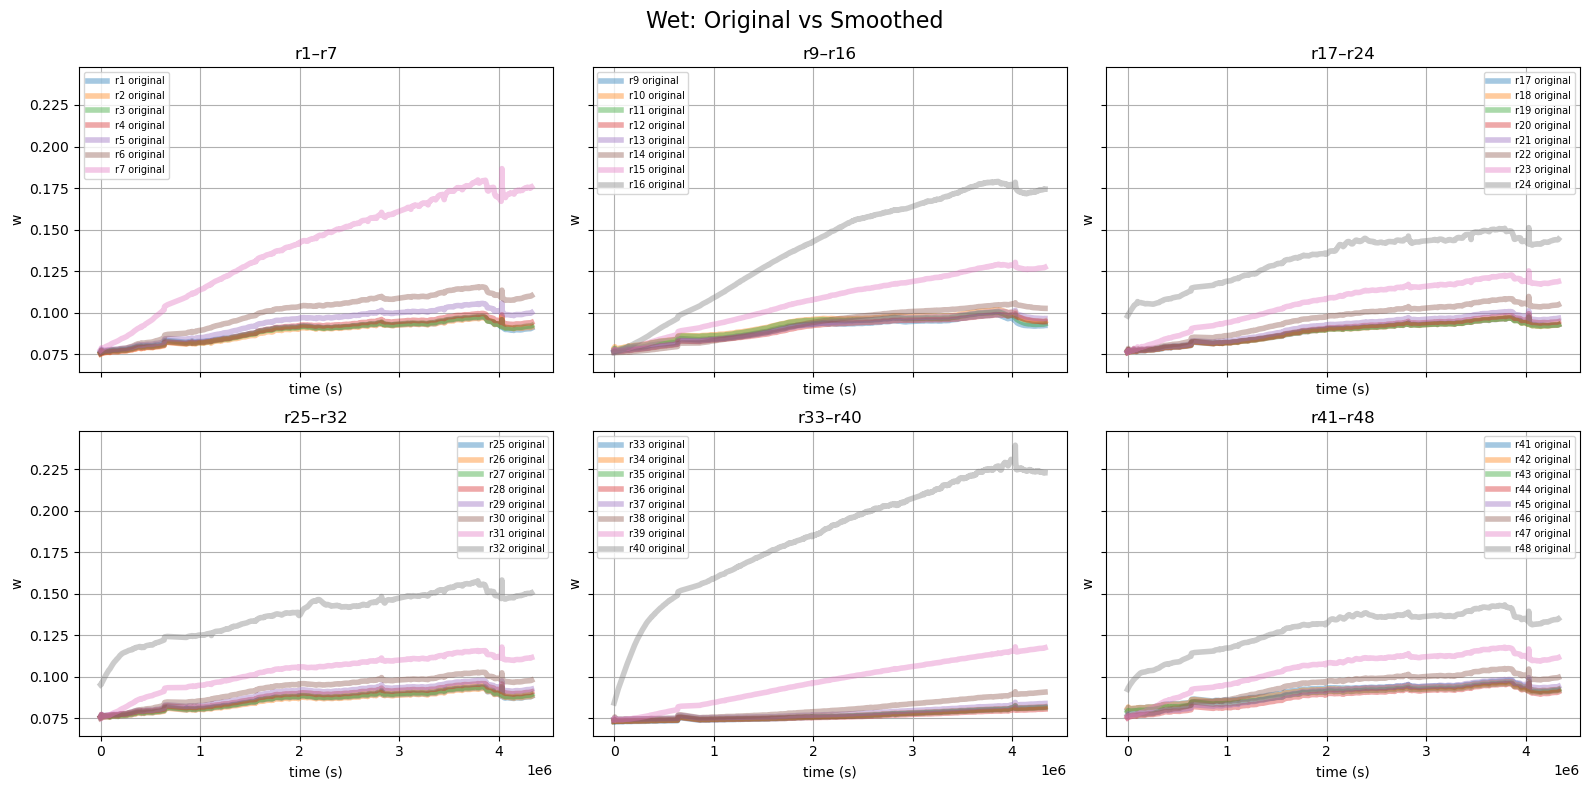

In [13]:
plot_r_groups(
    df_orig=w_wet,
    time_col=datetime_col_new,
    groups=groups,
    df_smooth=None,
    plot_original=True,
    plot_smooth=False,
    title="Wet: Original vs Smoothed"
)

## EMC ambient - smoothing and export

In [14]:
# select time + r49, r50
EMC_amb = w_wet[[datetime_col_new, 'r49', 'r50']]

# Create smoothed copy (same index + time)
EMC_amb_smooth = pd.DataFrame(index=EMC_amb.index)
EMC_amb_smooth[datetime_col_new] = EMC_amb[datetime_col_new]

roll = 0  # 1 = rolling median, 0 = savgol

if roll == 1:
    # --- Rolling median ---
    window = 10  # window size in samples

    for c in ['r49', 'r50']:
        EMC_amb_smooth[c] = (
            EMC_amb[c]
            .rolling(window=window, center=True, min_periods=1)
            .median()
        )

else:
    # --- Savitzky–Golay smoothing ---
    window_length = 100   # must be odd and <= number of rows
    polyorder = 1

    n_rows = len(EMC_amb)
    if window_length > n_rows:
        # adjust if your data is shorter
        window_length = n_rows if n_rows % 2 == 1 else n_rows - 1

    for c in ['r49', 'r50']:
        y = EMC_amb[c].to_numpy()

        # 1) smooth on the SAME grid
        y_smooth = savgol_filter(
            y,
            window_length=window_length,
            polyorder=polyorder
        )

        # 2) optionally enforce monotone increase:
        # y_smooth = np.maximum.accumulate(y_smooth)

        EMC_amb_smooth[c] = y_smooth

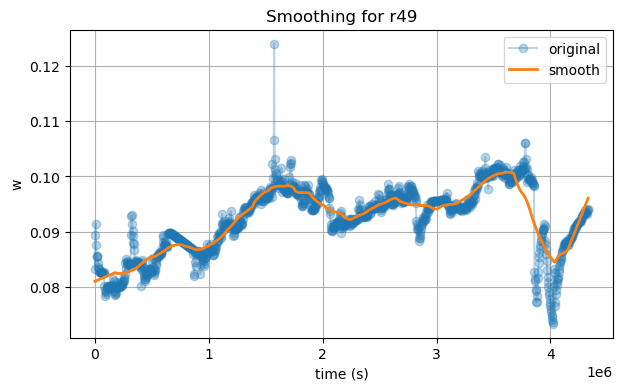

In [15]:
col_to_check = 'r49'  # pick any

plt.figure(figsize=(7, 4))
plt.plot(EMC_amb[datetime_col_new], EMC_amb[col_to_check],
         'o-', alpha=0.3, label='original')
plt.plot(EMC_amb_smooth[datetime_col_new], EMC_amb_smooth[col_to_check],
         '-', linewidth=2, label='smooth')
plt.xlabel(datetime_col_new)
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.title(f'Smoothing for {col_to_check}')
plt.show()

In [ ]:
EMC_amb_smooth.to_csv ('EMC_smooth.csv',index=False)

## W delta for comparison with COMSOL

In [16]:
w_wet_delta = w_wet[colnames_all].sub(w_wet[colnames_all].iloc[0])  # subtract first row
w_wet_delta[datetime_col_new] = w_wet[datetime_col_new]

w_dry_delta = w_dry[colnames_all].sub(w_dry[colnames_all].iloc[0])  # subtract first row
w_dry_delta[datetime_col_new] = w_dry[datetime_col_new]

# smoothing data

# Create smoothed copy
w_smooth = pd.DataFrame(index=w_wet_delta.index)
w_smooth[datetime_col_new] = w_wet_delta[datetime_col_new]

roll = 0  # 1 = rolling median, 0 = savgol

if roll == 1:
    # rolling median
    window = 200   # choose window size (can be even here)
    for c in colnames_all:
        w_smooth[c] = (
            w_wet_delta[c]
            .rolling(window=window, center=True, min_periods=1)
            .median()
        )

else:
    # Savitzky–Golay smoothing
    polyorder = 1
    n_rows = len(w_wet_delta)

    # choose base window_length
    window_length = 31  # some starting odd number

    # ensure window_length <= n_rows and odd
    #if window_length > n_rows:
    #    window_length = n_rows if n_rows % 2 == 1 else n_rows - 1

    for c in colnames_all:
        y = w_wet_delta[c].to_numpy()

        # 1) smooth on the SAME grid
        y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)

        # 2) optionally enforce monotone increase:
        #y_smooth = np.maximum.accumulate(y_smooth)

        w_smooth[c] = y_smooth


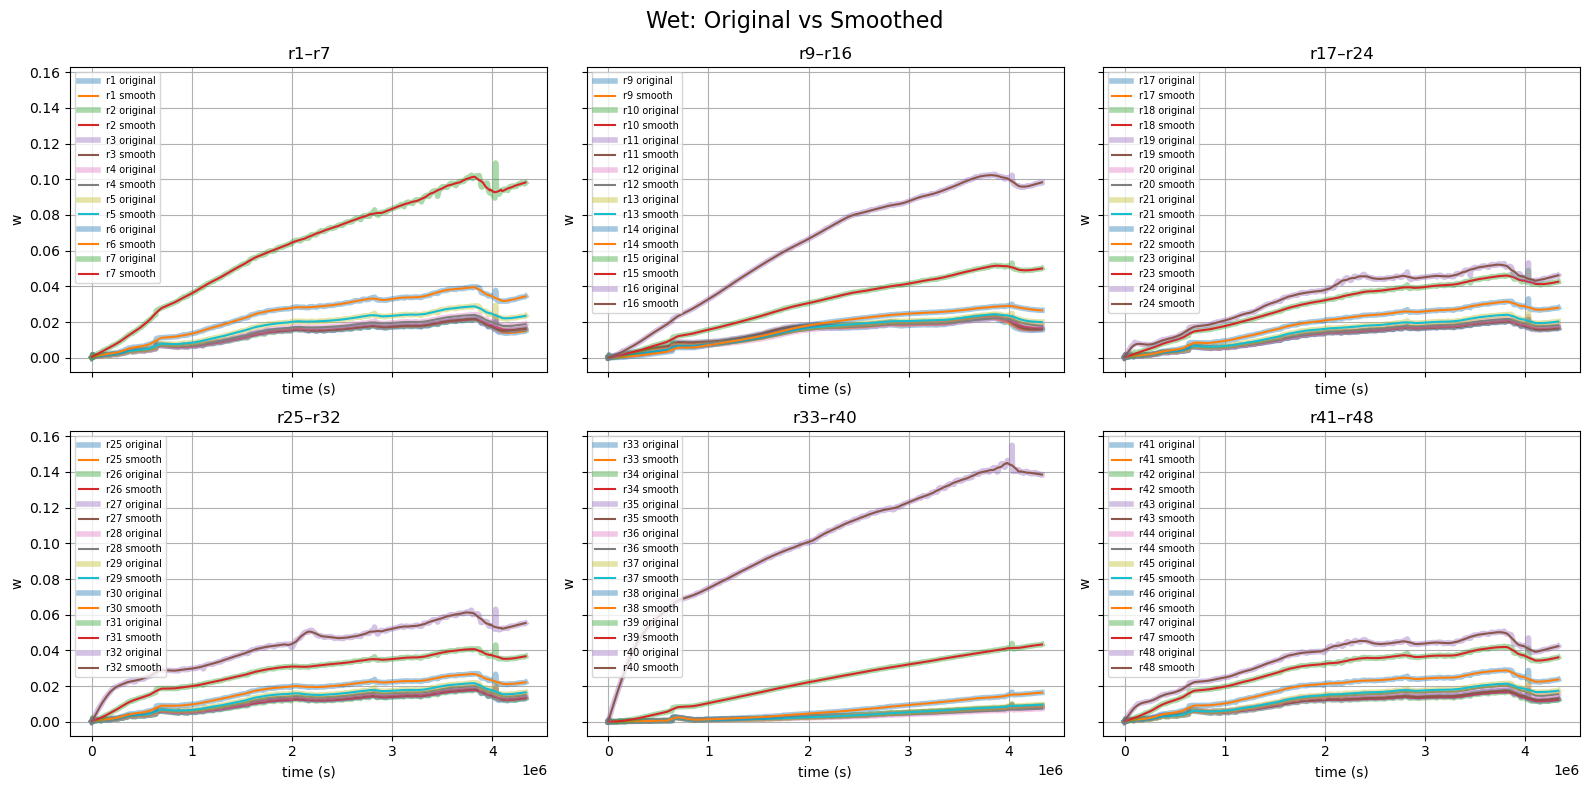

In [17]:
plot_r_groups(
    df_orig=w_wet_delta,
    time_col=datetime_col_new,
    groups=groups,
    df_smooth=w_smooth,
    plot_original=True,
    plot_smooth=True,
    title="Wet: Original vs Smoothed"
)

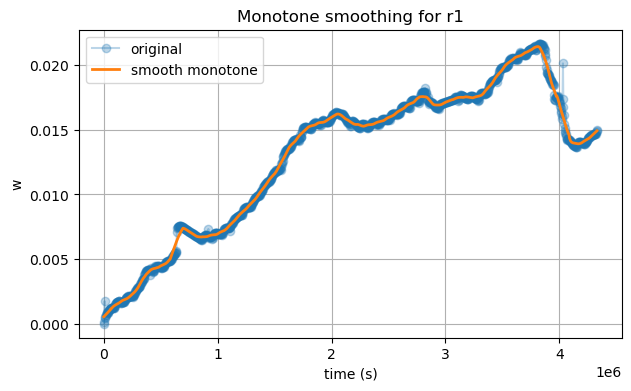

In [18]:
col_to_check = 'r1'  # pick any

plt.figure(figsize=(7, 4))
plt.plot(w_wet_delta[datetime_col_new], w_wet_delta[col_to_check],
         'o-', alpha=0.3, label='original')
plt.plot(w_smooth[datetime_col_new], w_smooth[col_to_check],
         '-', linewidth=2, label='smooth monotone')
plt.xlabel(datetime_col_new)
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.title(f'Monotone smoothing for {col_to_check}')
plt.show()

## Plot 3D 

In [20]:
import numpy as np, re
import matplotlib.pyplot as plt
from matplotlib import colormaps

def plot_sensors_3d(
    df,
    cols_spec,
    time_col=datetime_col_new ,
    drop=None,
    cmap_name="viridis",
    stride=1,
    elev=25,
    azim=-135,
    zlabel="R (-)",
    title="Sensors 3D surface",
    y_as_index=True,
    wireframe=False,
    save_png=None,
    # --- NEW: labeling + visibility options ---
    group_map=None,
    y_tick_step=1,          # show every Nth tick (1 = all)
    y_labelsize=11,         # larger labels
    y_tick_pad=8,           # extra padding from axis spine
    show_group_separators=True,
):
    """
    group_map: optional dict {sensor_col: ("S"|"M"|"SL", height_float)}
               Example: {"r1":("S",0.9), "r2":("S",0.8), ..., "r9":("M",0.9), ...}
               If provided, y labels become 'S 0.9', 'M 0.8', 'SL 0.1' etc.
               If omitted, fallback to index-based labels.
    """
    drop = set(drop or [])

    # Expand sensor column spec
    def _expand_cols(spec, prefix="r"):
        # supports "r1-r24", "r1-r7,r9-r16,r19-r24"
        parts = []
        for chunk in str(spec).split(","):
            chunk = chunk.strip()
            m = re.match(rf"{prefix}?(\d+)\s*-\s*{prefix}?(\d+)", chunk)
            if m:
                a, b = int(m.group(1)), int(m.group(2))
                rng = range(min(a,b), max(a,b)+1)
                parts.extend([f"{prefix}{i}" for i in rng])
            else:
                m2 = re.match(rf"{prefix}?(\d+)$", chunk)
                if m2:
                    parts.append(f"{prefix}{int(m2.group(1))}")
        # de-dup in order
        seen, out = set(), []
        for p in parts:
            if p not in seen:
                seen.add(p); out.append(p)
        return out

    cols = _expand_cols(cols_spec, prefix="r")
    cols = [c for c in cols if (c not in drop) and (c in df.columns)]
    if len(cols) == 0:
        raise ValueError("No matching columns to plot.")

    # X = time
    if time_col not in df.columns:
        raise ValueError(f"time column '{time_col}' not found in df.")
    x = np.asarray(df[time_col], dtype=float)

    # Z = values matrix (n_times x n_sensors)
    Z = np.column_stack([np.asarray(df[c], dtype=float) for c in cols])

    # Subsample for speed
    x_s = x[::stride]
    Z_s = Z[::stride, :]

    # ----- Build Y positions + labels -----
    if group_map:
        # map each col -> (group_tag, height) else fallback gracefully
        tags, heights = [], []
        for c in cols:
            if c in group_map:
                g, h = group_map[c]
                tags.append(str(g))
                heights.append(float(h))
            else:
                # fallback: infer by suffix number if map missing
                m = re.search(r"(\d+)$", c); idx = int(m.group(1)) if m else np.nan
                tags.append("G")
                heights.append(idx)

        # keep original order but create numeric y positions 0..n-1
        y_s = np.arange(len(cols), dtype=float)

        # Build compact labels "S 0.9", "M 0.8", "SL 0.7"
        labels_full = [f"{t} {h:.1f}" for t, h in zip(tags, heights)]

        # Thin labels by y_tick_step
        tick_idxs = np.arange(len(cols))[::max(1, int(y_tick_step))]
        y_tick_positions = y_s[tick_idxs]
        y_tick_labels = [labels_full[i] for i in tick_idxs]

        # For separators & group captions we need group boundaries
        # collect contiguous blocks of same tag:
        boundaries = []
        start = 0
        for i in range(1, len(tags)+1):
            if i == len(tags) or tags[i] != tags[i-1]:
                boundaries.append((tags[start], start, i-1))
                start = i
    else:
        # original behavior
        if y_as_index:
            def _to_idx(c):
                m = re.search(r"(\d+)$", str(c))
                return int(m.group(1)) if m else np.nan
            y_vals = np.array([_to_idx(c) for c in cols], dtype=float)
            if not np.isfinite(y_vals).all():
                y_vals = np.arange(1, len(cols) + 1, dtype=float)
            y_s = y_vals
            labels_full = [str(int(v)) for v in y_vals]
        else:
            y_s = np.arange(len(cols), dtype=float)
            labels_full = cols
        tick_idxs = np.arange(len(labels_full))[::max(1, int(y_tick_step))]
        y_tick_positions = y_s[tick_idxs]
        y_tick_labels = [labels_full[i] for i in tick_idxs]
        boundaries = []

    # Build meshgrid
    X, Y = np.meshgrid(x_s, y_s, indexing="xy")  # shape (n_sensors, n_times)
    Z_plot = Z_s.T  # align Z with Y (sensors) vs X (time)

    # Mask NaNs
    Z_masked = np.ma.masked_invalid(Z_plot)

    # --- Plot ---

    fig = plt.figure(figsize=(14, 9), constrained_layout=True)   # instead of (11, 7)
    ax = fig.add_subplot(111, projection="3d")
    ax.tick_params(axis="y", pad=15)  # more distance between axis spine and labels

    #fig = plt.figure(figsize=(14, 9), constrained_layout=True)
    

    if wireframe:
        ax.plot_wireframe(X, Y, Z_masked, rstride=1, cstride=1)
    else:
        cmap = colormaps.get_cmap(cmap_name)
        surf = ax.plot_trisurf(
            X.ravel(), Y.ravel(), Z_masked.ravel(),
            cmap=cmap, linewidth=0.0, antialiased=True
        )
        cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=14, pad=0.03)
        cbar.set_label(zlabel)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Sensor")
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Improved tick visibility
    ax.set_yticks(y_tick_positions)
    #ax.set_yticklabels(y_tick_labels, fontsize=y_labelsize)
    ax.set_yticklabels(y_tick_labels, fontsize=12, rotation=30, ha="right")
    ax.tick_params(axis="y", pad=y_tick_pad)

    # Extra breathing room
    ax.set_ylim(y_s.min() - 0.5, y_s.max() + 0.5)

    # Group separators + captions (only when group_map is used)
    if show_group_separators and group_map and boundaries:
        # pick the far/right “wall” in X/Z to place lines & text
        x_max = np.nanmax(x_s)
        z_mid = np.nanmean(Z_masked) if np.isfinite(Z_masked).any() else 0.0
        # draw horizontal lines at group boundaries
        for tag, start, end in boundaries:
            y_mid = (start + end) / 2.0
            # group caption on the back wall
            #ax.text(x_max, y_mid, z_mid, tag,
             #       zdir='x', fontsize=y_labelsize+1, fontweight='bold',
              #      ha='left', va='center')
            # boundary lines (above and below block)
            ax.plot([x_s[0], x_max], [start-0.5, start-0.5],
                    [z_mid, z_mid], linewidth=1, alpha=0.5)
            ax.plot([x_s[0], x_max], [end+0.5, end+0.5],
                    [z_mid, z_mid], linewidth=1, alpha=0.5)

    ax.view_init(elev=elev, azim=azim)
    # keep this part you already have:
    ax.set_zlabel(zlabel, labelpad=1)   # pull Z label inside
    ax.tick_params(axis='y', pad=20)     # push Y ticks outward

    # replace tight_layout/subplots_adjust with this:
    fig.set_constrained_layout_pads(
    w_pad=2.0/72,   # width padding (inches→points conversion handled)
    h_pad=2.0/72,   # height padding
    wspace=0.15,    # space between columns
    hspace=0.15,    # space between rows
    )

    if save_png:
        fig.savefig(save_png, dpi=300, bbox_inches="tight")
    plt.show()


def make_group_map(cols, group_order=("S","M","SL"), heights=np.round(np.linspace(0.9, 0.1, 9),1)):
    """
    Assigns the first len(heights) cols to group_order[0],
    next len(heights) to group_order[1], etc.
    Returns dict {col: (group_tag, height)}.
    """
    gmap = {}
    per_group = len(heights)
    for i, c in enumerate(cols):
        g_idx = i // per_group
        h_idx = i % per_group
        tag = group_order[min(g_idx, len(group_order)-1)]
        gmap[c] = (tag, float(heights[h_idx]))
    return gmap

/var/folders/y_/s7jxg14916nc9xn1wcttf3cw0000gn/T/ipykernel_19118/1128176784.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(save_png, dpi=300, bbox_inches="tight")


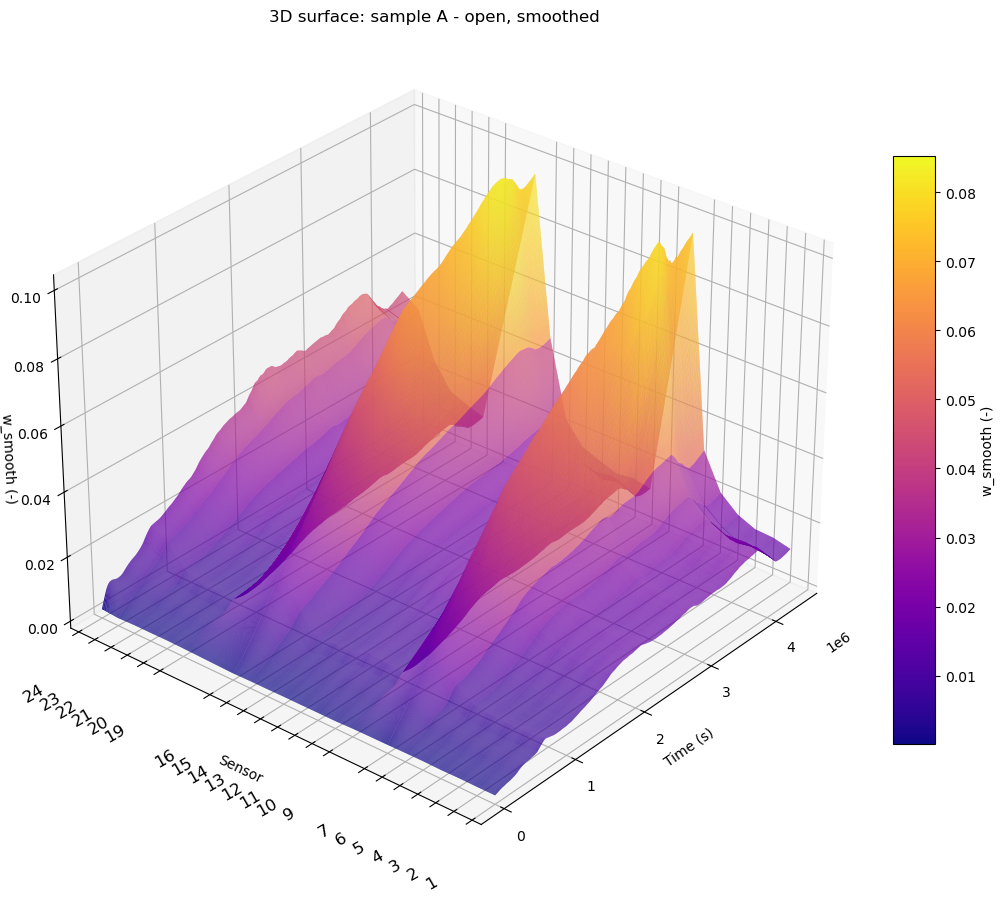

/var/folders/y_/s7jxg14916nc9xn1wcttf3cw0000gn/T/ipykernel_19118/1128176784.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(save_png, dpi=300, bbox_inches="tight")


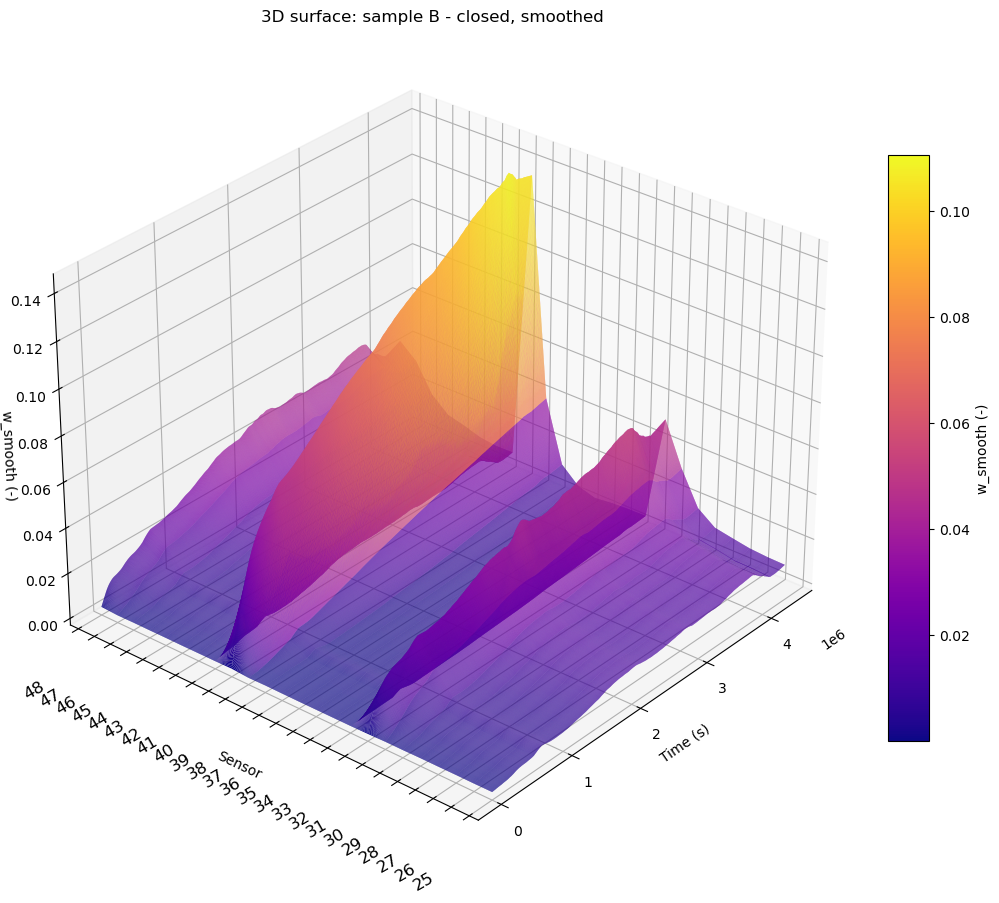

In [21]:
# Plot raw w, sensors r1–r24
#plot_sensors_3d(w_smooth, cols_spec="r1-r24", zlabel="w (-)", title="3D surface: w raw")

# Plot smoothed subset with dropped sensors
plot_sensors_3d(
    w_smooth,
    cols_spec="r1-r7,r9-r16,r19-r24",
    zlabel="w_smooth (-)",
    title="3D surface: sample A - open, smoothed",
    cmap_name="plasma",
    elev=30,
    azim=-140,
    save_png="sample1_smooth_3d.png"
)

# Plot smoothed subset with dropped sensors
plot_sensors_3d(
    w_smooth,
    cols_spec="r25-r32,r33-r40,r41-r48",
    zlabel="w_smooth (-)",
    title="3D surface: sample B - closed, smoothed",
    cmap_name="plasma",
    elev=30,
    azim=-140,
    save_png="sample2_smooth_3d.png"
)

# Mass measurement

In [22]:
# get table of temperatures and set time to seconds
mass = df["m"].copy()

# Subtract datetime separately
datetime_col = "cas"
datetime_col_new = "time (s)"
mass[datetime_col_new ] = mass[datetime_col] - mass.iloc[0][datetime_col]
## Date to minutes and seconds
mass[datetime_col_new ] = mass[datetime_col_new ].dt.total_seconds()
mass

,cas,open,reference,closed,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,time (s)
0,2024-05-18 12:41:28,8955.1279,2975.9902,8909.7920,NaN,NaN,NaN,NaN,0.0
1,2024-05-18 12:42:28,8954.9707,2975.6990,8908.2275,NaN,NaN,NaN,NaN,60.0
2,2024-05-18 12:43:28,8955.4414,2976.3787,8907.9600,NaN,NaN,NaN,NaN,120.0
3,2024-05-18 12:44:28,8955.2061,2976.0000,8908.4951,NaN,NaN,NaN,NaN,180.0
4,2024-05-18 12:45:28,8955.3721,2975.9417,8908.8018,NaN,NaN,NaN,NaN,240.0
...,...,...,...,...,...,...,...,...,...
24684,2024-08-27 07:15:53,9047.9805,2980.8542,9125.1289,49.135021,81.6377,4.7766,221.2480,8706865.0
24685,2024-08-27 07:20:53,9048.0684,2981.2913,9124.3066,49.135869,81.7256,5.2137,220.4257,8707165.0
24686,2024-08-27 07:25:53,9047.9609,2981.0583,9124.5449,49.136717,81.6181,4.9807,220.6640,8707465.0
24687,2024-08-27 07:30:53,9048.0000,2981.1262,9125.6729,49.137565,81.6572,5.0486,221.7920,8707765.0


In [23]:
# Mass delta
mass_delta = pd.DataFrame()
mass_delta [datetime_col_new]= mass[datetime_col_new]  
mass_delta[['open', 'closed']] = mass[['open', 'closed']].sub(
    mass[['open', 'closed']].iloc[0], 
    axis=1
)
#mass_delta

## Moisture from mass 
w_mass = pd.DataFrame()
w_mass [datetime_col_new]= mass[datetime_col_new]
w_mass[['open', 'closed']] = mass_delta[['open', 'closed']].div(mass[['open', 'closed']].iloc[0], 
    axis=1
)
#print (w_mass)
#print (mass_delta)
#print (mass)

In [24]:
# split for wetting and drying part
last_time = w_mass[datetime_col_new].iloc[-1]
half_time = last_time/2
#half_time = 300000
wetting = w_mass[datetime_col_new] < half_time
drying = w_mass[datetime_col_new] > half_time
#
w_mass_wet = w_mass [wetting]
w_mass_dry = w_mass [drying]
w_mass_wet

,time (s),open,closed
0,0.0,0.000000,0.000000
1,60.0,-0.000018,-0.000176
2,120.0,0.000035,-0.000206
3,180.0,0.000009,-0.000146
4,240.0,0.000027,-0.000111
...,...,...,...
14283,4352656.0,0.054014,0.040197
14284,4352956.0,0.053976,0.040182
14285,4353257.0,0.053980,0.040162
14286,4353557.0,0.053972,0.040267


In [25]:
## Smoothinhg
# smoothing data
## Smoothing
w_mass_smooth = pd.DataFrame(index=w_mass_wet.index)
w_mass_smooth[datetime_col_new] = w_mass_wet[datetime_col_new]  # keep time

roll = 1  # 1 = rolling median, 0 = savgol

if roll == 1:
    window = 5000  # rolling median

    for c in ['open', 'closed']:
        w_mass_smooth[c] = (
            w_mass_wet[c]
            .rolling(window=window, center=True, min_periods=1)
            .median()
        )

else:
    from scipy.signal import savgol_filter  # if using savgol

    window_length = 40
    polyorder = 1

    for c in ['open', 'closed']:
        y = w_mass_wet[c].to_numpy()
        y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)
        w_mass_smooth[c] = y_smooth

# Ensure both start at zero
for c in ['open', 'closed']:
    w_mass_smooth[c] = w_mass_smooth[c] - w_mass_smooth[c].iloc[0]


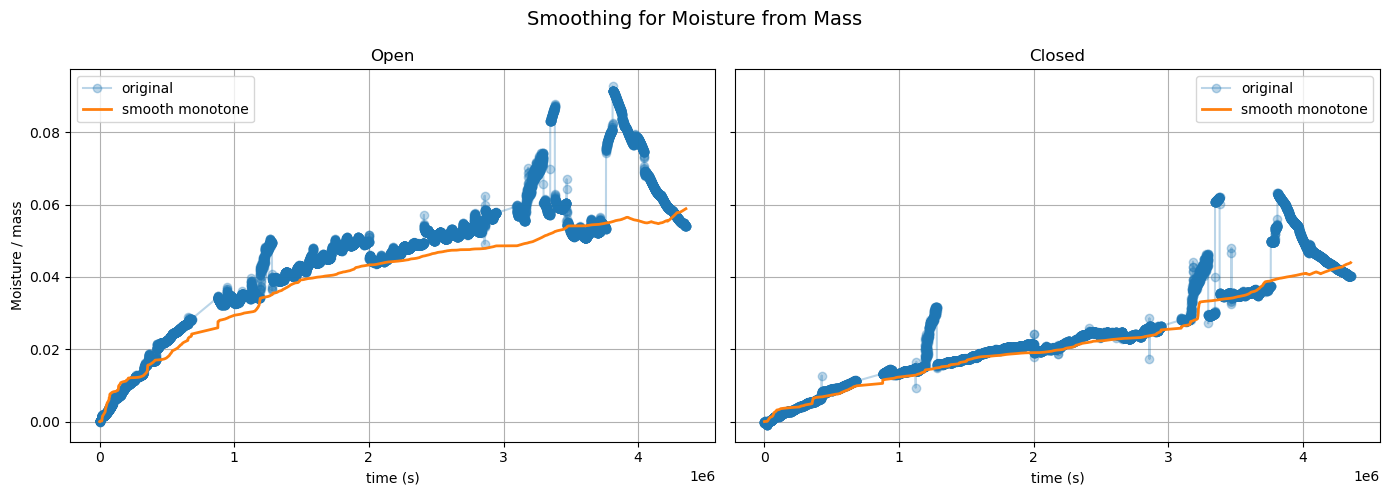

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# --- OPEN ---
ax = axes[0]
ax.plot(w_mass_wet[datetime_col_new], w_mass_wet['open'],
        'o-', alpha=0.3, label='original')
ax.plot(w_mass_smooth[datetime_col_new], w_mass_smooth['open'],
        '-', linewidth=2, label='smooth monotone')
ax.set_title("Open")
ax.set_xlabel(datetime_col_new)
ax.set_ylabel("Moisture / mass")
ax.grid(True)
ax.legend()

# --- CLOSED ---
ax = axes[1]
ax.plot(w_mass_wet[datetime_col_new], w_mass_wet['closed'],
        'o-', alpha=0.3, label='original')
ax.plot(w_mass_smooth[datetime_col_new], w_mass_smooth['closed'],
        '-', linewidth=2, label='smooth monotone')
ax.set_title("Closed")
ax.set_xlabel(datetime_col_new)
ax.grid(True)
ax.legend()

# --- FINAL ---
fig.suptitle("Smoothing for Moisture from Mass", fontsize=14)
plt.tight_layout()
plt.show()


In [27]:
def exp_model_zero_start(t, b, tau):
    """Exponential model that starts at 0: y = b * (1 - exp(-t / tau))"""
    return b * (1 - np.exp(-t / tau))

def smooth_exp_regression(df, time_col, cols):
    t = df[time_col].to_numpy()
    smooth = pd.DataFrame(index=df.index)
    smooth[time_col] = df[time_col]
    params = {}

    for c in cols:
        y = df[c].to_numpy()
        mask = np.isfinite(t) & np.isfinite(y)
        t_fit = t[mask]
        y_fit = y[mask]

        if len(t_fit) < 3:
            smooth[c] = np.nan
            params[c] = None
            continue

        # initial guesses
        b0 = y_fit.max()
        tau0 = (t_fit.max() - t_fit.min()) / 3

        try:
            popt, _ = curve_fit(exp_model_zero_start, t_fit, y_fit, p0=(b0, tau0), maxfev=10000)
            b, tau = popt
            
            smooth[c] = exp_model_zero_start(t, b, tau)  # evaluate full curve
            params[c] = {"b": b, "tau": tau}
        except RuntimeError:
            smooth[c] = np.nan
            params[c] = None

    return smooth, params


In [28]:
cols = ['open', 'closed']
w_mass_smooth_exp, exp_params = smooth_exp_regression(w_mass_wet, datetime_col_new, cols)
# After fitting using Option 2 model:

for name, p in exp_params.items():
    if p is not None:
        print(f"{name}: y(t) = {p['b']:.4f} * (1 - exp(-t / {p['tau']:.4f}))")
    else:
        print(f"{name}: fit failed or not enough points")


open: y(t) = 0.0699 * (1 - exp(-t / 1603813.9051))
closed: y(t) = 603.9714 * (1 - exp(-t / 54855978428.8897))


## COMSOL Validation

In [29]:
# Read the text file
df_clt_valid = pd.read_csv(
    "clt1d_open_closed.txt",     # path of the uploaded file
    sep=r"\s+",             # split by ANY whitespace
    skiprows=5,             # skip COMSOL header metadata
    header = None
    #names=["Time (s)", "c_b (1)", "c_b_first (1)"]  # rename columns
)
df_clt_valid

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0.101128,0.000000,0.101136,0.000000,0.101133,0.000000,0.101131,0.000000,0.101131,...,0.101131,0.000000,0.101131,0.000000,0.101131,0.000000,0.101132,0.000000,0.101132,0.000000
1,43308,0.107600,0.006472,0.108111,0.006975,0.105338,0.004205,0.103106,0.001974,0.102099,...,0.102194,0.001063,0.102734,0.001603,0.102734,0.001603,0.103039,0.001907,0.103216,0.002084
2,86616,0.111041,0.009913,0.111671,0.010535,0.107764,0.006630,0.104569,0.003437,0.103108,...,0.103272,0.002141,0.104084,0.002953,0.104084,0.002953,0.104519,0.003387,0.104770,0.003639
3,129924,0.113652,0.012524,0.114394,0.013258,0.109611,0.008478,0.105710,0.004579,0.103913,...,0.104132,0.003001,0.105123,0.003992,0.105123,0.003992,0.105656,0.004525,0.105959,0.004827
4,173232,0.115830,0.014702,0.116671,0.015534,0.111167,0.010034,0.106663,0.005531,0.104602,...,0.104839,0.003708,0.106008,0.004876,0.106007,0.004875,0.106609,0.005478,0.106965,0.005834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,4157568,0.163397,0.062269,0.173344,0.072207,0.152502,0.051368,0.130253,0.029122,0.122552,...,0.124792,0.023661,0.130128,0.028996,0.130124,0.028993,0.132865,0.031733,0.134519,0.033387
97,4200876,0.163732,0.062604,0.173735,0.072599,0.152832,0.051699,0.130461,0.029330,0.122724,...,0.124993,0.023862,0.130346,0.029214,0.130351,0.029219,0.133101,0.031970,0.134773,0.033641
98,4244184,0.164075,0.062947,0.174129,0.072993,0.153161,0.052028,0.130679,0.029547,0.122909,...,0.125206,0.024075,0.130585,0.029454,0.130588,0.029457,0.133360,0.032229,0.135031,0.033899
99,4287492,0.164414,0.063286,0.174515,0.073379,0.153488,0.052354,0.130893,0.029761,0.123108,...,0.125419,0.024288,0.130822,0.029691,0.130826,0.029695,0.133612,0.032481,0.135287,0.034156


In [30]:
clt_cm = {}  # outer dict

# --- OPEN ---
clt_cm['open'] = {}  # create nested dict FIRST
clt_cm['open']['Time (s)'] = df_clt_valid.iloc[:, 0].copy()
clt_cm['open']['w (-)'] = df_clt_valid.iloc[:, 1].copy()
clt_cm['open']['w_rel (-)'] = df_clt_valid.iloc[:, 2].copy()

# --- CLOSED ---
clt_cm['closed'] = {}  # create nested dict FIRST
clt_cm['closed']['Time (s)'] = df_clt_valid.iloc[:, 0].copy()
clt_cm['closed']['w (-)'] = df_clt_valid.iloc[:, 21].copy()
clt_cm['closed']['w_rel (-)'] = df_clt_valid.iloc[:, 22].copy()

clt_df = {
    'closed': pd.DataFrame(clt_cm['closed']),
    'open':   pd.DataFrame(clt_cm['open'])
}

# preview both:
for key, df in clt_df.items():
    print(f"\n--- {key} ---")
    print(df.head())


--- closed ---
   Time (s)     w (-)  w_rel (-)
0         0  0.101132   0.000000
1     43308  0.103216   0.002084
2     86616  0.104770   0.003639
3    129924  0.105959   0.004827
4    173232  0.106965   0.005834

--- open ---
   Time (s)     w (-)  w_rel (-)
0         0  0.101128   0.000000
1     43308  0.107600   0.006472
2     86616  0.111041   0.009913
3    129924  0.113652   0.012524
4    173232  0.115830   0.014702


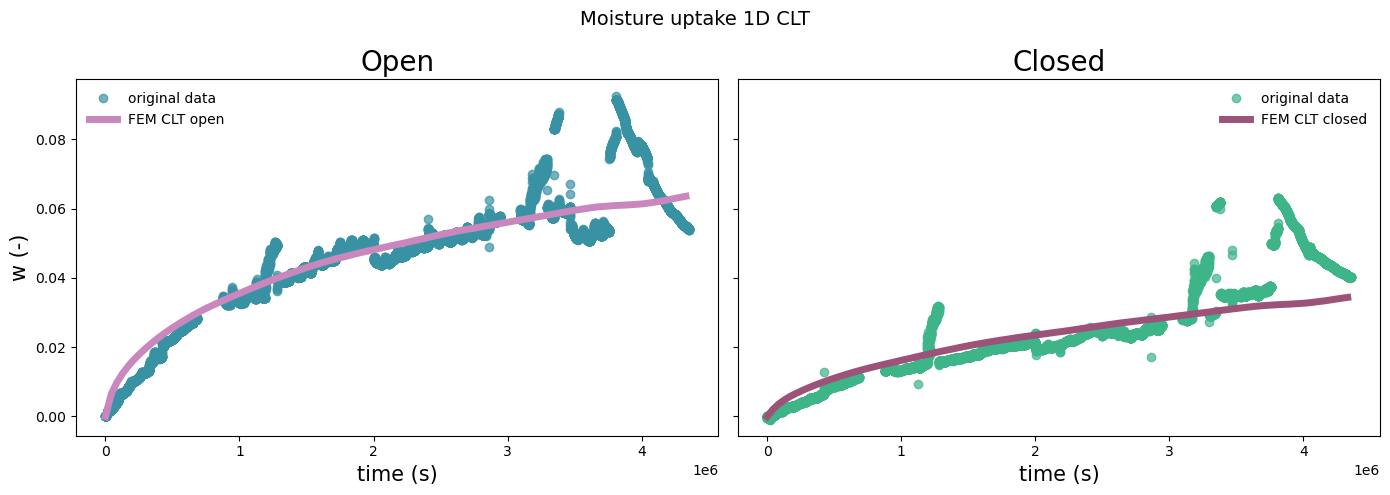

In [33]:
# Colors
mint_line_closed = '#3EB489'   # EXP closed (mint)
mint_fill_closed = '#A8E6CF'   # EXP closed fill
blue_line_open = '#3992A3'   # EXP open (orange)
blue_fill_open = '#A5ECFA'   # EXP open fill
pink_line_fem_o    = '#C987BD'   # FEM (COMSOL) curves
pink_line_fem_c    = '#9C5279'   # FEM (COMSOL) curves

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# --- OPEN ---
ax = axes[0]
ax.plot(
    w_mass_wet[datetime_col_new],
    w_mass_wet['open'],
    marker='o',
    linestyle='none',
    color=blue_line_open,
    alpha=0.7,
    label='original data'
)
#ax.plot(
#w_mass_smooth_exp[datetime_col_new],
#w_mass_smooth_exp['open'],
#    '-',
#    linewidth=2,
#    color=blue_line,
#    label='exp fit'
#)
# ➜ FEM / COMSOL curve (OPEN)
ax.plot(
    clt_df['open']['Time (s)'],
    clt_df['open']['w_rel (-)'],
    '-',
    linewidth=5,
    color=pink_line_fem_o,
    label='FEM CLT open'
)

ax.set_title("Open", fontsize=20)
ax.set_xlabel(datetime_col_new, fontsize=15)
ax.set_ylabel("w (-)", fontsize=15)
ax.grid(False)
ax.legend(frameon=False)

# --- CLOSED ---
ax = axes[1]
ax.plot(
    w_mass_wet[datetime_col_new],
    w_mass_wet['closed'],
    marker='o',
    linestyle='none',
    color=mint_line_closed,
    alpha=0.7,
    label='original data'
)
#ax.plot(
#    w_mass_smooth_exp[datetime_col_new],
#    w_mass_smooth_exp['closed'],
#    '-',
#    linewidth=2,
#    color=blue_line,
#    label='exp fit'
#)
# ➜ FEM / COMSOL curve (CLOSED)
ax.plot(
    clt_df['closed']['Time (s)'],
    clt_df['closed']['w_rel (-)'],
    '-',
    linewidth=5,
    color=pink_line_fem_c,
    label='FEM CLT closed'
)

ax.set_title("Closed", fontsize=20)
ax.set_xlabel(datetime_col_new, fontsize=15)
ax.grid(False)
ax.legend(frameon=False)

fig.suptitle("Moisture uptake 1D CLT", fontsize=14)
plt.tight_layout()
plt.show()

fig.savefig('clt1d_valid_open_closed.png', dpi=300, bbox_inches="tight")

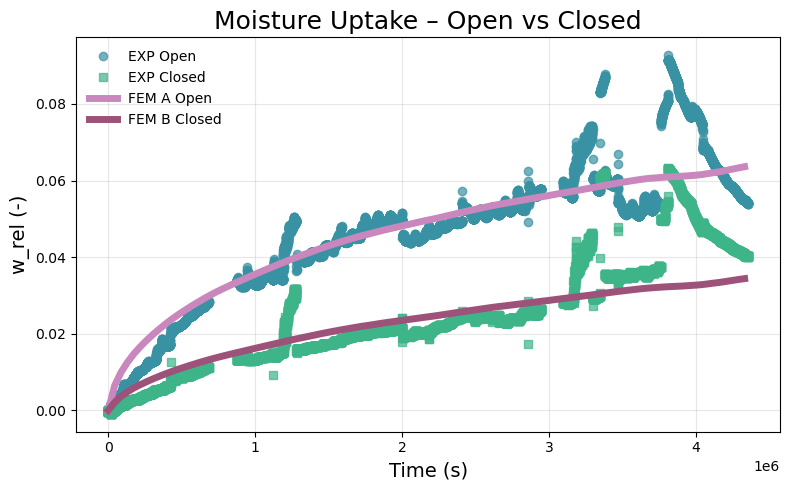

In [122]:
# Colors
mint_line_closed = '#3EB489'   # EXP closed (mint)
mint_fill_closed = '#A8E6CF'   # EXP closed fill
blue_line_open = '#3992A3'   # EXP open (orange)
blue_fill_open = '#A5ECFA'   # EXP open fill
pink_line_fem_o    = '#C987BD'   # FEM (COMSOL) curves
pink_line_fem_c    = '#9C5279'   # FEM (COMSOL) curves


fig, ax = plt.subplots(figsize=(8,5))

# --- EXPERIMENTAL DATA (scatter) ---
# Open
ax.plot(
    w_mass_wet[datetime_col_new],
    w_mass_wet['open'],
    marker='o',
    linestyle='none',
    color=blue_line_open,
    alpha=0.7,
    label='EXP Open'
)

# Closed
ax.plot(
    w_mass_wet[datetime_col_new],
    w_mass_wet['closed'],
    marker='s',          # different marker to visually separate
    linestyle='none',
    color=mint_line_closed,
    alpha=0.7,
    label='EXP Closed'
)


# --- FEM (COMSOL) CURVES ---
# Open FEM
ax.plot(
    clt_df['open']['Time (s)'],
    clt_df['open']['w_rel (-)'],
    '-',
    linewidth=5,
    color=pink_line_fem_o,
    label='FEM A Open'
)

# Closed FEM
ax.plot(
    clt_df['closed']['Time (s)'],
    clt_df['closed']['w_rel (-)'],
    '-',
    linewidth=5,
    color=pink_line_fem_c,
    label='FEM B Closed'
)

# --- PLOT SETTINGS ---
ax.set_title("Moisture Uptake – Open vs Closed", fontsize=18)
ax.set_xlabel("Time (s)", fontsize=14)
ax.set_ylabel("w_rel (-)", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- SAVE FIGURE ---
fig.savefig('clt1d_valid_exp_vs_fem.png', dpi=300, bbox_inches="tight")


In [45]:
w_mass_smooth_exp.to_csv ('w1D_smooth_exp.csv',index=False)

## Curve smoothing by function - second option

In [34]:
def biexp_model(t, a, b1, tau1, b2, tau2):
    return a + b1 * np.exp(-t/tau1) + b2 * np.exp(-t/tau2)

def smooth_biexp_regression(df, time_col, cols):
    t = df[time_col].to_numpy()
    smooth = pd.DataFrame(index=df.index)
    smooth[time_col] = df[time_col]
    params = {}

    for c in cols:
        y = df[c].to_numpy()

        mask = np.isfinite(t) & np.isfinite(y)
        t_fit, y_fit = t[mask], y[mask]

        if len(t_fit) < 5:
            smooth[c] = np.nan
            params[c] = None
            continue

        # Initial guesses
        a0 = y_fit[-1]
        b10 = (y_fit[0] - a0) * 0.7
        b20 = (y_fit[0] - a0) * 0.3
        tau10 = (t_fit.max() - t_fit.min()) / 4
        tau20 = (t_fit.max() - t_fit.min()) / 10

        try:
            popt, _ = curve_fit(
                biexp_model,
                t_fit, y_fit,
                p0=(a0, b10, tau10, b20, tau20),
                maxfev=20000
            )
            smooth[c] = biexp_model(t, *popt)
            params[c] = dict(zip(['a','b1','tau1','b2','tau2'], popt))
        except:
            smooth[c] = np.nan
            params[c] = None

    return smooth, params


In [35]:
cols = ['open', 'closed']
w_mass_smooth_biexp, biexp_params = smooth_biexp_regression(w_mass_wet, datetime_col_new, cols)

# print equations
for name, p in biexp_params.items():
    if p:
        print(f"{name}: y = {p['a']:.4f} + {p['b1']:.4f} exp(-t/{p['tau1']:.4f})"
              f" + {p['b2']:.4f} exp(-t/{p['tau2']:.4f})")
    else:
        print(f"{name}: fitting failed")

open: y = 0.1389 + -0.1120 exp(-t/9305943.3973) + -0.0279 exp(-t/499255.6421)
closed: y = 385.0281 + -196.6567 exp(-t/35084688679.8464) + -188.3703 exp(-t/37598403033.3417)


In [36]:
w_mass_smooth_biexp.to_csv ('clt1d_wmass_biexp.csv',index = False)

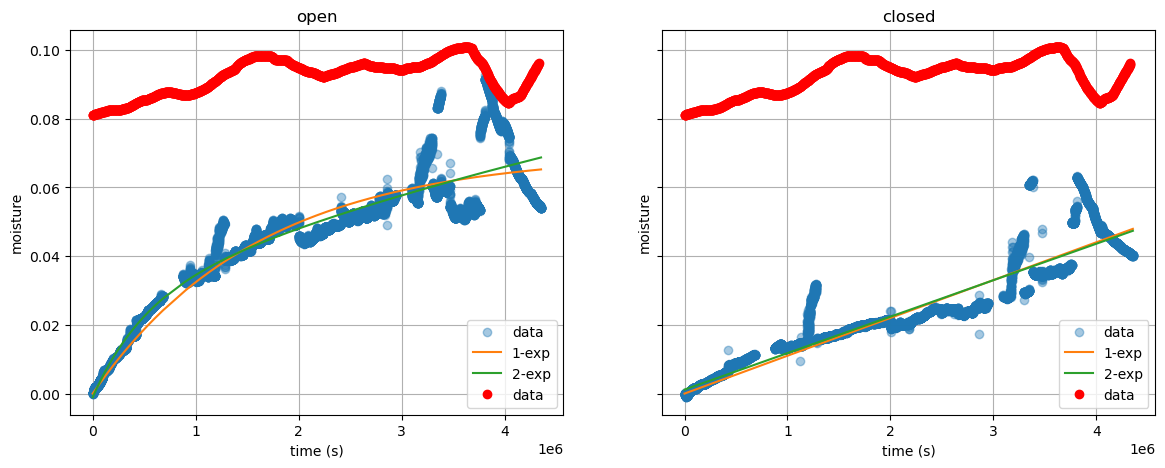

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

for i, col in enumerate(['open', 'closed']):
    ax = axes[i]

    ax.plot(w_mass_wet[datetime_col_new], w_mass_wet[col],
            'o', alpha=0.4, label='data')

    ax.plot(w_mass_smooth_exp[datetime_col_new], w_mass_smooth_exp[col],
            label='1-exp')
    ax.plot(w_mass_smooth_biexp[datetime_col_new], w_mass_smooth_biexp[col],
            label='2-exp')

    ax.plot(EMC_amb_smooth[datetime_col_new], EMC_amb_smooth['r49'],
            'o', alpha=1, label='data', color = 'red')

    ax.set_title(col)
    ax.set_xlabel(datetime_col_new)
    ax.set_ylabel("moisture")
    ax.grid(True)
    ax.legend()


## Calculating density for dry wood
### Density by the equation with k_av
$$
rho_w = rho_0 * \frac{(1+EMC)}{(1 + k_{av} * EMC)}
$$

In [23]:
w_for_dens = w_wet['r1'].iloc[0]
mass_for_dens = mass ['open'].iloc[0]

print (w_for_dens)
print (mass_for_dens)

0.07578537656922
8955.1279


In [25]:
k_av = 0.5
dens_mer_s1 = (mass_for_dens / 1000) / (0.2 * 0.1 * 0.9)
rho_0_mer_s1  = dens_mer_s1*(1+k_av*w_for_dens)/(1+w_for_dens)

print (dens_mer_s1)
print(rho_0_mer_s1)

497.50710555555537
479.98327405459594
